# 2.04 Forecasting Metrics. (This may be better suited as 2.05)

In [72]:
import pandas as pd 
import numpy as np
import os
import sys 
from pathlib import Path
import matplotlib.pyplot as plt

import tsforge as tsf

import warnings
from functools import partial
from utilsforecast.losses import (
    nd as wmape,
    mae,
    rmse,
    bias,
    mase
)
from utilsforecast.evaluation import evaluate

In [73]:
train_df = pd.read_parquet(
    "/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/data/output/m5_weekly.parquet"
)

df = pd.read_parquet(
    "/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/statsforecast_backtest.parquet"
)

* sku level metrics computation using utilsforecast, across all skus and timesteps

* computing metrics for all cutoffs and models, the loop is only necessary for accurate MASE calculations

In [74]:
model_cols = [col for col in df.columns if col not in ['unique_id','ds','y','cutoff'] 
and 'lo-' not in col and 'hi-' not in col]

metric_df = evaluate(
    df = df,
    train_df=train_df,
    metrics=[rmse,mae,bias,wmape,partial(mase,seasonality=1)],
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    models=model_cols,
    # aggregate but add nan_to_num for inf handling
    agg_fn=lambda x: np.nanmean(np.nan_to_num(x,posinf=np.nan,neginf=np.nan)) 
    
    # get mean across all skus and all timesteps, agg_fn = None is simply computing metric(s) for all skus
) 

In [75]:
metric_df

,metric,Naive,CrostonOptimized,MA4,SN52,HW52,AutoTheta,AutoMFLES,AutoETS
0,rmse,6.649233,5.813695,5.983487,7.819209,7.109518,5.948742,6.939166,5.960287
1,mae,5.076145,4.626363,4.594436,6.068500,5.656146,4.558240,5.457426,4.560902
2,bias,-0.605595,0.038228,-0.071782,-0.814517,-0.511148,-0.168630,-0.077805,-0.166727
3,nd,0.791909,0.777168,0.711402,0.956918,0.896308,0.705456,0.900731,0.712307
4,mase,1.196083,1.092946,1.067859,1.398300,1.280710,1.054919,1.277653,1.063727


In [76]:

sku_metrics = []
for cutoff in df["cutoff"].unique():
    train_data_sub = train_df.loc[train_df["ds"] <= cutoff]
    cv_df = df[
        (df["cutoff"] == cutoff) & (df["unique_id"].isin(train_data_sub["unique_id"].unique()))
    ]
    metric_df = evaluate(
        df=cv_df,
        train_df=train_data_sub,
        metrics=[rmse, mae, bias, wmape, partial(mase, seasonality=1)],
        id_col="unique_id",
        time_col="ds",
        target_col="y",
        agg_fn=None,
        models=model_cols,
    ).assign(cutoff=cutoff)

    sku_metrics.append(metric_df)

sku_tab = pd.concat(sku_metrics)

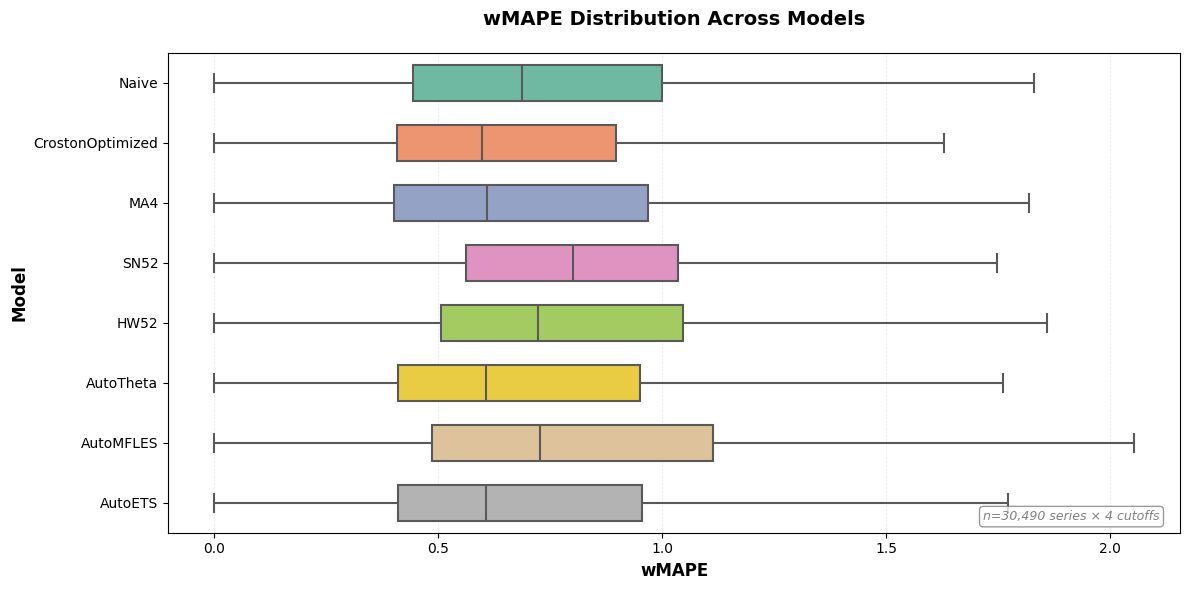


📊 ND Summary Statistics by Model:
                     count  mean  std  min    25%    50%    75%  max
model                                                               
AutoETS           121696.0   inf  NaN  0.0  0.414  0.620  0.988  inf
AutoMFLES         121696.0   inf  NaN  0.0  0.491  0.742  1.163  inf
AutoTheta         121696.0   inf  NaN  0.0  0.414  0.619  0.984  inf
CrostonOptimized  121696.0   inf  NaN  0.0  0.414  0.610  0.933  inf
HW52              121696.0   inf  NaN  0.0  0.512  0.736  1.093  inf
MA4               121696.0   inf  NaN  0.0  0.403  0.613  0.979  inf
Naive             121696.0   inf  NaN  0.0  0.444  0.688  1.000  inf
SN52              121696.0   inf  NaN  0.0  0.566  0.812  1.071  inf


In [77]:
# ============================================================================
# BEAUTIFUL BOXPLOT: Model Performance Comparison
# ============================================================================

import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
METRIC = 'nd'
metric_labels = {
    'nd': 'wMAPE',
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Squared Error',
    'mase': 'Mean Absolute Scaled Error'
}

# Prepare data
plot_data = (
    sku_tab
    .query("metric == @METRIC")
    .melt(id_vars=["unique_id", "metric", "cutoff"], 
          var_name="model", 
          value_name=METRIC)
)

# Create figure with better proportions
fig, ax = plt.subplots(figsize=(12, 6))

# Create boxplot with refined styling
sns.boxplot(
    data=plot_data,
    y="model",  # Models on y-axis (easier to read labels)
    x=METRIC,
    palette="Set2",  # Professional color palette
    ax=ax,
    showfliers=False,  # Hide outliers for cleaner look
    width=0.6,  # Slightly narrower boxes
    linewidth=1.5,  # Thicker box lines
    saturation=0.8  # Slightly muted colors
)

# Styling
ax.set_xlabel(
    metric_labels.get(METRIC, METRIC.upper()), 
    fontsize=12, 
    fontweight='bold'
)
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title(
    f'{metric_labels.get(METRIC, METRIC.upper())} Distribution Across Models',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid for better readability
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)  # Grid behind boxes

# Add sample size annotation
n_series = plot_data['unique_id'].nunique()
n_cutoffs = plot_data['cutoff'].nunique()
ax.text(
    0.98, 0.02,
    f'n={n_series:,} series × {n_cutoffs} cutoffs',
    transform=ax.transAxes,
    ha='right',
    va='bottom',
    fontsize=9,
    style='italic',
    color='gray',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.tight_layout()
plt.show()

print(f"\n📊 {METRIC.upper()} Summary Statistics by Model:")
print(plot_data.groupby("model")[METRIC].describe().round(3))